In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [8]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
import blackjax
import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb

import sys

from bamojax.base import Model
from bamojax.samplers import mcmc_sampler
from bamojax.inference import SMCInference


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Numpyro version:    ', npr.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:         0.7.2
BlackJax version:    1.2.5
Numpyro version:     0.19.0
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


# Eight schools

The famous example of a hierarchical model.

The data are:

In [3]:
means = jnp.array([28, 8, -3, 7, -1, 1, 18, 12])
stddevs = jnp.array([15, 10, 16, 11, 9, 11, 10, 18])

J = len(means)

The model definition is:

In [4]:
ES = Model('eight schools')
mu = ES.add_node('mu', distribution=dist.Normal(loc=0, scale=10))
tau = ES.add_node('tau', distribution=dist.TransformedDistribution(dist.Normal(loc=5, scale=1), nprb.ExpTransform()))
theta = ES.add_node('theta', distribution=dist.Normal, parents=dict(loc=mu, scale=tau), shape=(J, ))
y = ES.add_node('y', distribution=dist.Normal, parents=dict(loc=theta, scale=stddevs), observations=means)

Set up inference:

In [5]:
mcmc_params = dict(sigma=4.0*jnp.eye(ES.get_model_size()))
rmh_kernel = mcmc_sampler(ES, mcmc_kernel=blackjax.normal_random_walk, mcmc_parameters=mcmc_params)

num_particles = 10_000
num_mutations = 100
num_chains = 4

key = jrnd.PRNGKey(0)

engine = SMCInference(model=ES, num_chains=num_chains, mcmc_kernel=rmh_kernel, num_particles=num_particles, num_mutations=num_mutations)
result = engine.run(key)

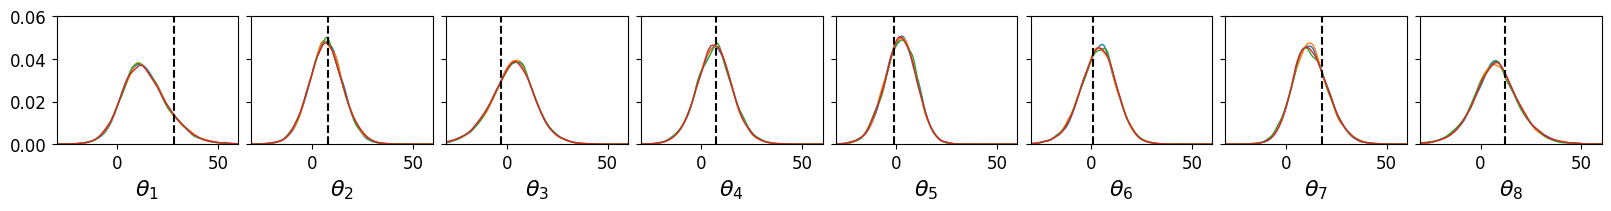

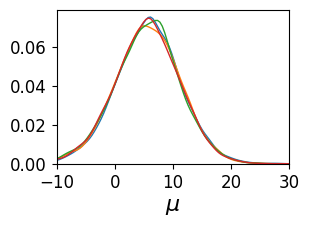

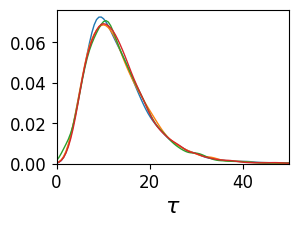

In [6]:
_, axes = plt.subplots(nrows=1, ncols=J, sharex=True, sharey=True, constrained_layout=True, figsize=(16, 2))

xlim = [-30, 60]
xrange = jnp.linspace(*xlim, 100)

for i, ax in enumerate(axes):
    for c in range(num_chains):
        pdf = gaussian_kde(result['final_state'].particles['theta'][c, :, i])
        ax.plot(xrange, pdf(xrange), lw=1)
    ax.axvline(x=means[i], ls='--', color='k')
    ax.set_ylim([0.0, 0.06])
    ax.set_xlim(*xlim)
    ax.set_xlabel(fr'$\theta_{i+1}$', fontsize=MEDIUM_SIZE)
plt.show()

mu_range = jnp.linspace(-10, 30, 100)
plt.figure(figsize=(3, 2))
ax = plt.gca()
for c in range(num_chains):
    pdf = gaussian_kde(result['final_state'].particles['mu'][c, :])
    ax.plot(mu_range, pdf(mu_range), lw=1)
ax.set_xlim([-10, 30])
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\mu$', fontsize=MEDIUM_SIZE);
plt.show()

tau_range = jnp.linspace(0, 50, 100)
plt.figure(figsize=(3, 2))
ax = plt.gca()
for c in range(num_chains):
    pdf = gaussian_kde(result['final_state'].particles['tau'][c, :])
    ax.plot(tau_range, pdf(tau_range), lw=1)
ax.set_xlim([0, 50])
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$\tau$', fontsize=MEDIUM_SIZE);
plt.show()

In [7]:
posterior_mean = jnp.mean(result['final_state'].particles['theta'].flatten())
posterior_std = jnp.std(result['final_state'].particles['theta'].flatten())

print(f'Posterior mean: {posterior_mean:0.3f}')
print(f'Posterior stddev: {posterior_std:0.3f}')

Posterior mean: 6.969
Posterior stddev: 10.588
